In [1]:
#import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sumithsingh/blood-cell-images-for-cancer-detection")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2


In [4]:
data= '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2'

files = os.listdir(data)
print("Arquivos disponíveis no dataset:", files)

Arquivos disponíveis no dataset: ['seg_neutrophil', 'monocyte', 'basophil', 'erythroblast', 'myeloblast']


In [5]:
SEED = 42
np.random.seed(SEED)

In [6]:
CLASSES = ['monocyte', 'erythroblast', 'basophil', 'seg_neutrophil', 'myeloblast']

In [7]:
for class_name in CLASSES:
  print(f"{class_name}: {len(os.listdir(os.path.join(data, class_name)))}images")

monocyte: 1000images
erythroblast: 1000images
basophil: 1000images
seg_neutrophil: 1000images
myeloblast: 1000images


In [8]:
for class_name in CLASSES:
  for img_file in os.listdir(os.path.join(data, class_name)):
    try:
      img = cv2.imread(os.path.join(data, class_name, img_file))
    except:
        print(f"Corrupt file: {img_file}")

this code iterates through all image files, attempts to read each one using cv2.imread(), and if it cant read, it prints a message indicating a possible corrupted file.

Exibindo imagens da classe: monocyte


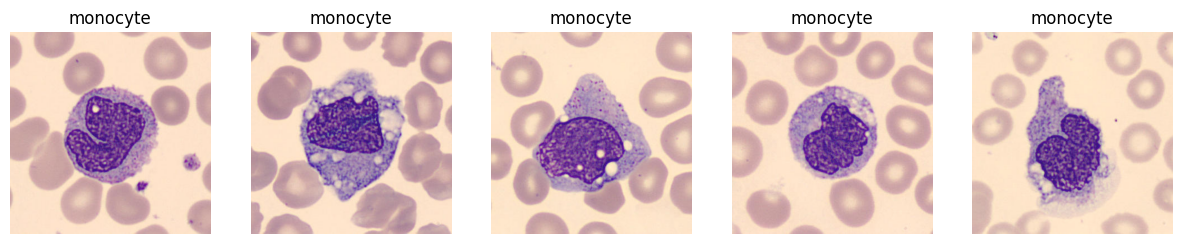

Exibindo imagens da classe: erythroblast


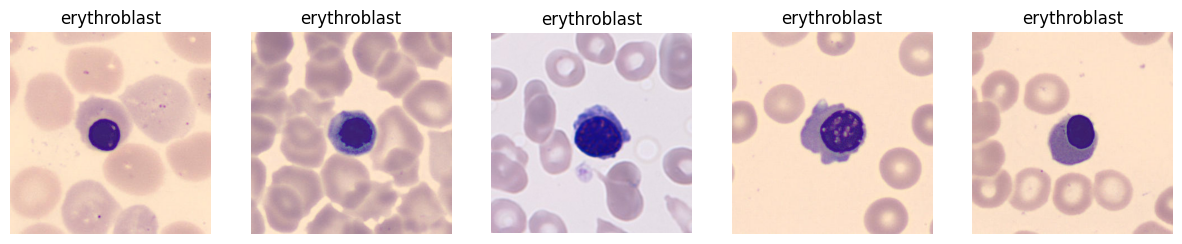

Exibindo imagens da classe: basophil


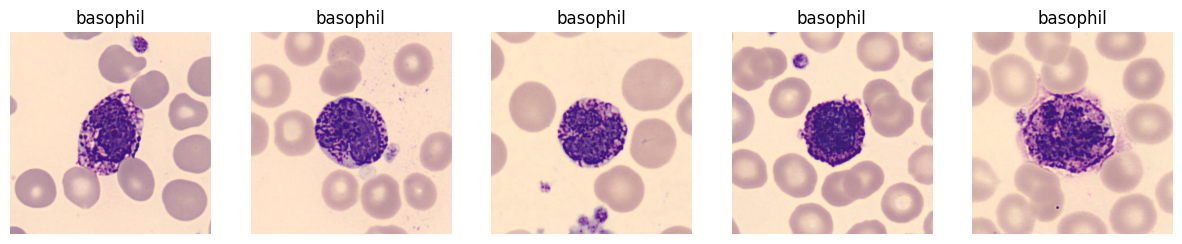

Exibindo imagens da classe: seg_neutrophil


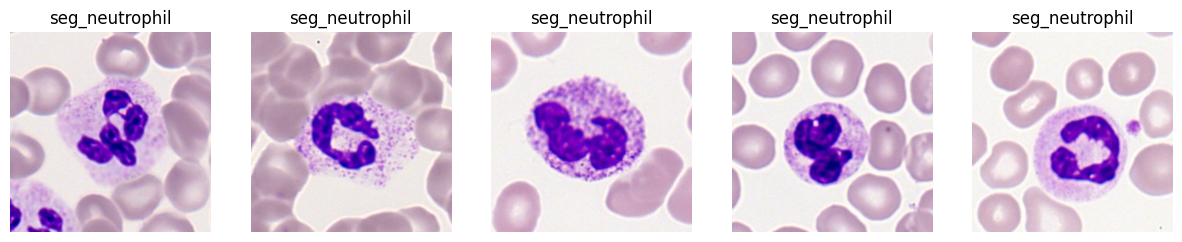

Exibindo imagens da classe: myeloblast


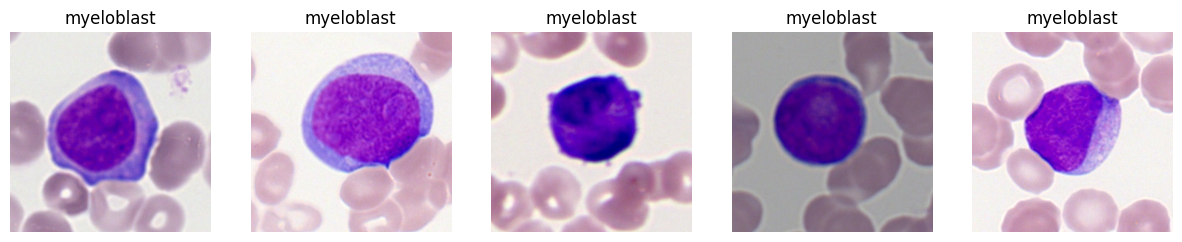

In [9]:
import os
import cv2

num_images_to_show = 5

#images per class
for class_name in CLASSES:
  class_path = os.path.join(data, class_name)
  images = os.listdir(class_path)[:num_images_to_show]

  print(f"Exibindo imagens da classe: {class_name}")
  plt.figure(figsize=(15,5))

  for i, img_file in enumerate(images):
    img_path = os.path.join(class_path, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

  plt.show()

In [10]:
#Define image size
img_height, img_width = 128, 128

In [11]:
#initialize empty arrays for data and labels
images = []
labels = []

In [12]:
#Load image into arrays
for class_index, class_name in enumerate(CLASSES):
  folder_path = os.path.join(data, class_name)
  for img_file in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path, img_file))
    img = cv2.resize(img, (img_height, img_width))
    images.append(img)
    labels.append(class_index)
images = np.array(images)
labels = np.array(labels)


In [13]:
#Data preprocessing
images = images / 255.0


In [14]:
#Convert labels to categorical format
labels = to_categorical(labels, num_classes=len(CLASSES))

In [15]:
#split data into train validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size = 0.3, random_state = SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = SEED)

In [16]:
#initialize image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True

)
datagen.fit(X_train)

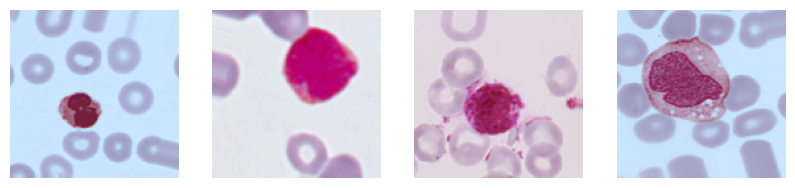

In [17]:
#display augmented images
augmented_images = next(datagen.flow(X_train, y_train, batch_size=4))
fig, axes = plt.subplots(1, 4, figsize = (10, 5))
for i, img in enumerate(augmented_images[0]):
  axes[i].imshow(img)
  axes[i].axis('off')

plt.show()

In [18]:
#model building and training
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(pool_size = (2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation = 'softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


- CNN: apply filters to the input image to extract features
- MaxPooling: These layers reduce the spatial dimensions of the feature maps outputted by the convolutional layers.
This helps to reduce the number of parameters and computation in the network, while also making the model more robust to small variations in the  input.
- Batch Normalization: This layer helps to stabilize and speed up training by normalizing the activations of the previous layer. Prevent overfitting.

- Flatten Layer: This layer converts the multi-dimensional feature maps into a single, long vector. This is necessary to connect the convolutional layers to the fully connected layers.

In [19]:
#compile th model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
#display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,518,213 (24.87 MB)

 Trainable params: 6,517,765 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [21]:
#Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs = 20,
    steps_per_epoch=len(X_train) // 32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 28s 182ms/step - accuracy: 0.6870 - loss: 2.1347 - val_accuracy: 0.1973 - val_loss: 19.8559
Epoch 2/20
  1/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8750 - loss: 0.3207

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.3207 - val_accuracy: 0.1973 - val_loss: 20.1764
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.8814 - loss: 0.4992 - val_accuracy: 0.1973 - val_loss: 22.6654
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 1.9366 - val_accuracy: 0.1973 - val_loss: 21.0099
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.9073 - loss: 0.3472 - val_accuracy: 0.1973 - val_loss: 33.3416
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8750 - loss: 0.5064 - val_accuracy: 0.1973 - val_loss: 34.2367
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.9317 - loss: 0.2810 - val_accuracy: 0.3120 - val_loss: 12.3043
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.3024 - val_accuracy: 0.3280 - val_loss: 11.3317
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.9337 - loss: 0.2439 - val_accu

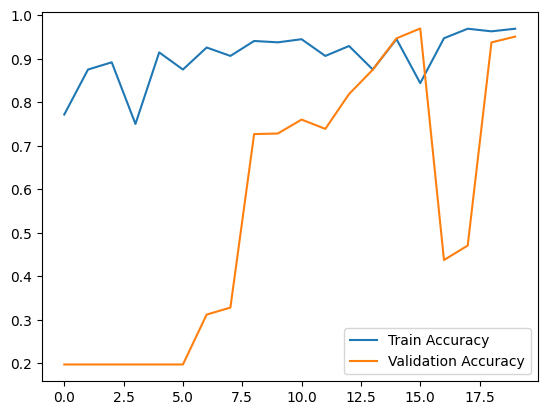

In [22]:
#plot training performance
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()

In [23]:
#evaluation and deployment
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9697 - loss: 0.1085
Test Accuracy: 0.96


In [24]:
#Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [25]:
#display classification report
print(classification_report(y_true, y_pred_classes, target_names = CLASSES))

                precision    recall  f1-score   support

      monocyte       1.00      0.89      0.94       157
  erythroblast       0.91      0.99      0.95       161
      basophil       0.96      0.96      0.96       142
seg_neutrophil       0.97      0.99      0.98       153
    myeloblast       0.99      0.99      0.99       137

      accuracy                           0.96       750
     macro avg       0.97      0.96      0.96       750
  weighted avg       0.97      0.96      0.96       750



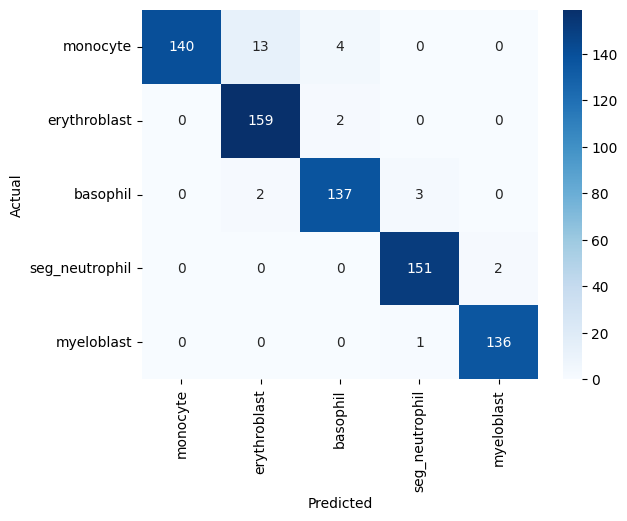

In [26]:
#plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = 'd', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [27]:
#save the trained model
model.save('blood_cell_classifier.keras')

In [28]:
#load the saved model
from tensorflow.keras.models import load_model
loaded_model = load_model('blood_cell_classifier.keras')

In [29]:
#test with a new image
# Correct the file path to the actual location of the image
# Ensure the file exists and you have permission to access it
img_path = '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/erythroblast/ERB_101031.jpg'

img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {img_path}. Check the file path and permissions.")
else:
    img = cv2.resize(img, (img_height, img_width)) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = np.argmax(loaded_model.predict(img))
    print(f"predicted class: {CLASSES[prediction]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
predicted class: erythroblast


In [30]:
#load and preprocess the image
import matplotlib.pyplot as plt

img_path = '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/seg_neutrophil/NGS_0022.jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (img_height, img_width)) / 255.0
img_expanded = np.expand_dims(img_resized, axis = 0 )

In [31]:
#make prediction
predictions = loaded_model.predict(img_expanded)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


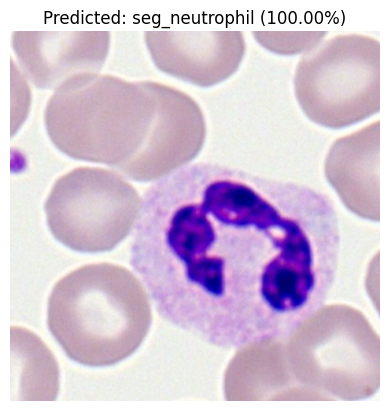

In [32]:
#display the predicted image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted: {CLASSES[predicted_class]} ({confidence:.2f}%)")
plt.show()

In [33]:
#print detailed output
print(f"Predicted class: {CLASSES[predicted_class]}")
print(f"Confidence: {confidence:.2f}%")

Predicted class: seg_neutrophil
Confidence: 100.00%


In [34]:
img_path = '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/monocyte/MO_104441.jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (img_height, img_width)) / 255.0
img_expanded = np.expand_dims(img_resized, axis = 0 )

In [35]:
#make prediction
predictions = loaded_model.predict(img_expanded)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


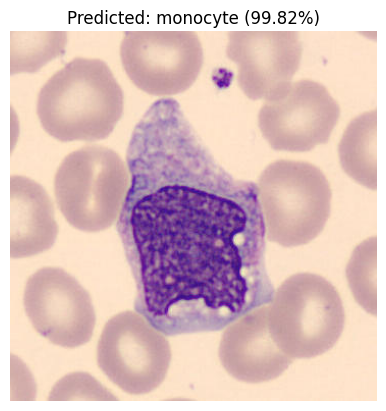

In [36]:
#display the predicted image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted: {CLASSES[predicted_class]} ({confidence:.2f}%)")
plt.show()

In [37]:
img_path = '/root/.cache/kagglehub/datasets/sumithsingh/blood-cell-images-for-cancer-detection/versions/2/erythroblast/ERB_101031.jpg'
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (img_height, img_width)) / 255.0
img_expanded = np.expand_dims(img_resized, axis = 0 )

In [38]:
#make prediction
predictions = loaded_model.predict(img_expanded)
predicted_class = np.argmax(predictions)
confidence = predictions[0][predicted_class] * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


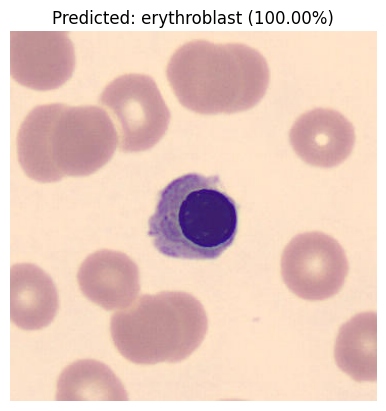

In [39]:
#display the predicted image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted: {CLASSES[predicted_class]} ({confidence:.2f}%)")
plt.show()